#Imports

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import product
from sklearn.preprocessing import LabelEncoder
import time
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras import optimizers, Sequential, Model
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

#Reading data

In [4]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bassantehab","key":"7e068bf1f317a4df5d16d53b0bf88c1a"}'}

In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle competitions download -c 'competitive-data-science-predict-future-sales'

 98% 13.0M/13.3M [00:00<00:00, 24.7MB/s]
100% 13.3M/13.3M [00:00<00:00, 33.5MB/s]
  0% 0.00/3.49k [00:00<?, ?B/s]
100% 3.49k/3.49k [00:00<00:00, 3.11MB/s]
  0% 0.00/1.02M [00:00<?, ?B/s]
100% 1.02M/1.02M [00:00<00:00, 165MB/s]
  0% 0.00/368k [00:00<?, ?B/s]
100% 368k/368k [00:00<00:00, 116MB/s]
  0% 0.00/468k [00:00<?, ?B/s]
100% 468k/468k [00:00<00:00, 294MB/s]
  0% 0.00/2.91k [00:00<?, ?B/s]
100% 2.91k/2.91k [00:00<00:00, 2.80MB/s]


In [7]:
! unzip test.csv.zip -d test
! unzip items.csv.zip -d items
! unzip sales_train.csv.zip -d sales_train
! unzip sample_submission.csv.zip -d sample_submission

Archive:  test.csv.zip
  inflating: test/test.csv           
Archive:  items.csv.zip
  inflating: items/items.csv         
Archive:  sales_train.csv.zip
  inflating: sales_train/sales_train.csv  
Archive:  sample_submission.csv.zip
  inflating: sample_submission/sample_submission.csv  


In [9]:
items = pd.read_csv("items.csv")
cats = pd.read_csv("item_categories.csv")
shops = pd.read_csv("shops.csv")
train = pd.read_csv("sales_train.csv")
test = pd.read_csv("test.csv")

#Data visualization and preparation 

In [10]:
train[train.item_cnt_day<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,05.01.2013,0,25,2552,899.0,-1.0
148,23.01.2013,0,25,2321,999.0,-1.0
175,07.01.2013,0,25,2199,1449.0,-1.0
807,02.01.2013,0,25,2330,599.0,-1.0
1041,13.01.2013,0,25,5034,1989.0,-1.0
...,...,...,...,...,...,...
2934243,26.10.2015,33,25,3917,449.0,-1.0
2934462,18.10.2015,33,25,4896,6398.0,-1.0
2935263,05.10.2015,33,25,10039,249.0,-1.0
2935643,16.10.2015,33,25,7893,2990.0,-1.0


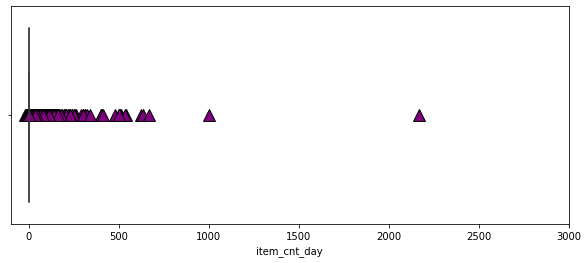

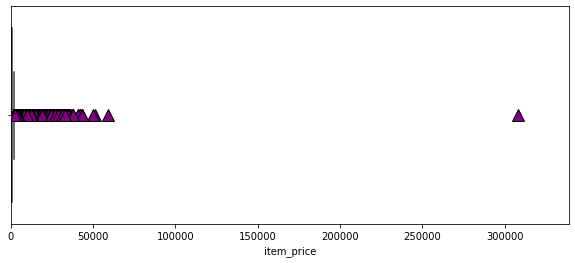

In [11]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
flierprops = dict(marker='^', markerfacecolor='purple', ms=12,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=train.item_cnt_day, flierprops=flierprops)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price, flierprops=flierprops)

In [12]:
train = train[(train.item_price < 300000 )& (train.item_cnt_day < 1000)]
train = train[train.item_price > 0].reset_index(drop = True)
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935840,10.10.2015,33,25,7409,299.00,1.0
2935841,09.10.2015,33,25,7460,299.00,1.0
2935842,14.10.2015,33,25,7459,349.00,1.0
2935843,22.10.2015,33,25,7440,299.00,1.0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


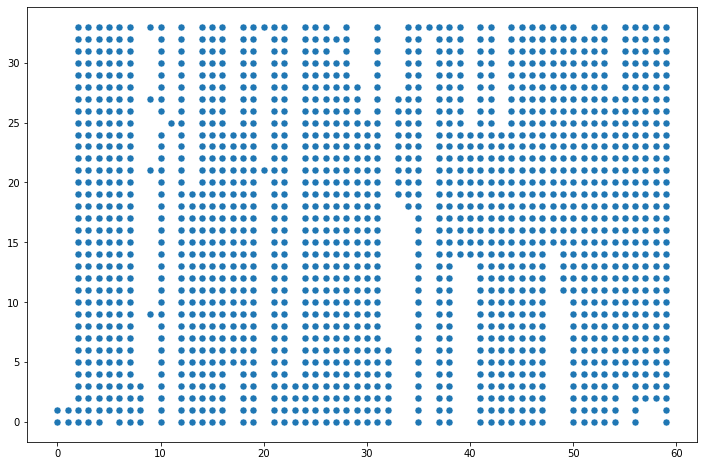

In [13]:
shop_id_month_list = []
for i in range(0,60):
    unq = train[train.shop_id==i].date_block_num.unique()
    #print(f"{i} {train[train.shop_id==i].date_block_num.unique()}")
    for j in unq:
       shop_id_month_list.append([i, j])
plt.figure(figsize = (12,8))
x, y = zip(*shop_id_month_list)
sns.scatterplot(x,y, s=50)
plt.show()

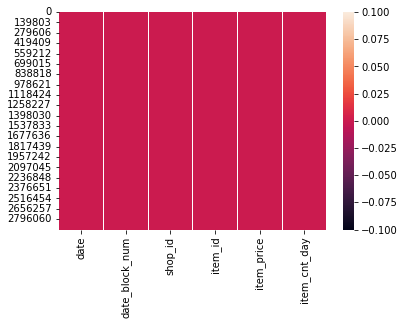

In [14]:
import seaborn as sns
sns.heatmap(train.isnull())

In [15]:
train = train[train['shop_id'].isin(test['shop_id'])]
train = train[train['item_id'].isin(test['item_id'].unique())]

In [16]:
train_data=pd.merge(train,items,on='item_id',how='inner')
train_data.drop('item_name',axis=1,inplace=True)
train_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.0,1.0,37
1,23.01.2013,0,24,22154,999.0,1.0,37
2,02.01.2013,0,25,22154,999.0,1.0,37
3,03.01.2013,0,25,22154,999.0,1.0,37
4,20.01.2013,0,25,22154,999.0,1.0,37


In [17]:
train_data['item_cnt_month']=train_data.groupby(['shop_id','item_id','date_block_num'])['item_cnt_day'].transform('sum')
train_data['monthly_sales']=train_data.groupby('date_block_num')['item_cnt_day'].transform('sum')
train_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,item_cnt_month,monthly_sales
0,02.01.2013,0,59,22154,999.0,1.0,37,1.0,20612.0
1,23.01.2013,0,24,22154,999.0,1.0,37,1.0,20612.0
2,02.01.2013,0,25,22154,999.0,1.0,37,5.0,20612.0
3,03.01.2013,0,25,22154,999.0,1.0,37,5.0,20612.0
4,20.01.2013,0,25,22154,999.0,1.0,37,5.0,20612.0


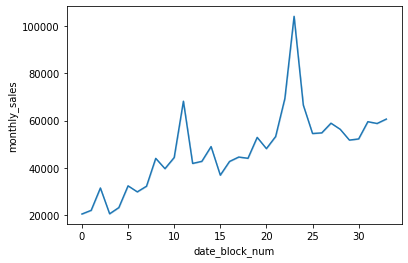

In [18]:
sns.lineplot(x='date_block_num', y='monthly_sales', data=train_data)

In [19]:
train_data=train_data[(train_data.item_cnt_month>=0) & (train_data.item_cnt_month<=15)]

In [20]:
mat= train_data.pivot_table(index=['shop_id', 'item_id'], columns='date_block_num',values='item_cnt_month', fill_value=0).reset_index()
mat.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,2,30,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,31,0,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2,32,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,2,2,0,2,0,0,1,0,0,0,0,1,0,0
3,2,33,1,0,0,0,0,0,0,0,0,0,2,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,1,0,1,0
4,2,53,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [21]:
first = 20
last = 33
sub_series = 12
l = []

for index, row in mat.iterrows():
    for i in range((last - (first + sub_series)) + 1):
        x = [row['shop_id'], row['item_id']]
        for j in range(sub_series + 1):
            x.append(row[i + first + j])
        l.append(x)

columns = ['shop_id', 'item_id']
[columns.append(i) for i in range(sub_series)]
columns.append('label')

mat1 = pd.DataFrame(l, columns=columns)
mat1.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,label
0,2,30,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,30,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,31,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2,31,0,0,0,0,0,0,0,0,0,0,0,0,1
4,2,32,2,2,0,2,0,0,1,0,0,0,0,1,0


In [22]:
mat1[(mat1['shop_id']==2) & (mat1['item_id']==31)]

,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,label
2,2,31,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2,31,0,0,0,0,0,0,0,0,0,0,0,0,1


In [23]:
y = mat1['label']
mat1.drop(['label','shop_id','item_id'], axis=1, inplace=True)

In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(mat1, y.values, test_size=0.1, random_state=0)

In [25]:
X_train1 = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid1 = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))

In [30]:
train_dataset = X_train1.copy()
test_dataset = X_valid1.copy()
nsamples, nx, ny = train_dataset.shape
d2_train_dataset = train_dataset.reshape((nsamples,nx*ny))
nsample, mmx, mmy = test_dataset.shape
d2_test_dataset = test_dataset.reshape((nsample,mmx*mmy))

#LSTM

In [27]:
lstm_model = Sequential()
lstm_model.add(LSTM(X_train1.shape[1], input_shape=(X_train1.shape[1], X_train1.shape[2]), return_sequences=True))
lstm_model.add(LSTM(6, activation='relu', return_sequences=True))
lstm_model.add(LSTM(6, activation='relu', return_sequences=True))
lstm_model.add(LSTM(1, activation='relu'))
lstm_model.add(Dense(10, kernel_initializer='glorot_normal', activation='relu'))
lstm_model.add(Dense(10, kernel_initializer='glorot_normal', activation='relu'))
lstm_model.add(Dense(1))
lstm_model.summary()

adam = optimizers.Adam(0.0001)
lstm_model.compile(loss='mse', optimizer=adam)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 12, 12)            672       
_________________________________________________________________
lstm_4 (LSTM)                (None, 12, 6)             456       
_________________________________________________________________
lstm_5 (LSTM)                (None, 12, 6)             312       
_________________________________________________________________
lstm_6 (LSTM)                (None, 1)                 32        
_________________________________________________________________
dense_3 (Dense)              (None, 10)                20        
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [28]:
lstm_model.fit(X_train1, y_train, validation_data=(X_valid1, y_valid), batch_size=128, epochs=10, verbose=1)

Epoch 1/10
1564/1564 [==============================] - 30s 16ms/step - loss: 1.2144 - val_loss: 1.1467
Epoch 2/10
1564/1564 [==============================] - 25s 16ms/step - loss: 1.1444 - val_loss: 1.1223
Epoch 3/10
1564/1564 [==============================] - 25s 16ms/step - loss: 1.1223 - val_loss: 1.1051
Epoch 4/10
1564/1564 [==============================] - 25s 16ms/step - loss: 1.1056 - val_loss: 1.0898
Epoch 5/10
1564/1564 [==============================] - 25s 16ms/step - loss: 1.0922 - val_loss: 1.0781
Epoch 6/10
1564/1564 [==============================] - 25s 16ms/step - loss: 1.0816 - val_loss: 1.0691
Epoch 7/10
1564/1564 [==============================] - 25s 16ms/step - loss: 1.0729 - val_loss: 1.0612
Epoch 8/10
1564/1564 [==============================] - 25s 16ms/step - loss: 1.0651 - val_loss: 1.0539
Epoch 9/10
1564/1564 [==============================] - 25s 16ms/step - loss: 1.0575 - val_loss: 1.0471
Epoch 10/10
1564/1564 [==============================] - 25s 16m

In [29]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score, r2_score
preds=lstm_model.predict(X_valid1)
print('MAE',mean_absolute_error(y_valid, preds))
print('MSE',mean_squared_error(y_valid, preds))

MAE 0.5507087567849616
MSE 1.038865784087794


#Lasso

In [31]:
lasso_model= Lasso(max_iter = 6000)
lasso_model.fit(d2_train_dataset,y_train)
price_predict =(lasso_model.predict(d2_test_dataset))
lasso_mse = mean_squared_error(y_valid,price_predict) 
print("Mean Squared Error : " , lasso_mse)
lasso_SqMse = np.sqrt(lasso_mse)
print("Root Mean Squared error: ", lasso_SqMse)

Mean Squared Error :  1.2583326756543474
Root Mean Squared error:  1.1217542848834354


#Random Forest

In [44]:
forest_model= RandomForestRegressor(n_estimators = 50, random_state = 42)
forest_model.fit(d2_train_dataset,y_train)
price_predict =(forest_model.predict(d2_test_dataset))
forest_mse = mean_squared_error(y_valid,price_predict)
print("Mean Squared Error : " , forest_mse)
forest_SqMse = np.sqrt(forest_mse)
print("Root Mean Squared error: ", forest_SqMse)

Mean Squared Error :  0.9928958205836159
Root Mean Squared error:  0.9964415791122005


#XGB Regressor

In [45]:
xgbr=  XGBRegressor()
xgbr.fit(d2_train_dataset,y_train)
price_predict =(xgbr.predict(d2_test_dataset))
xgbr_mse = mean_squared_error(y_valid,price_predict)
print("Mean Squared Error : " , xgbr_mse)
xgbr_SqMse = np.sqrt(xgbr_mse)
print("Root Mean Squared error: ", xgbr_SqMse)

[15:52:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Squared Error :  0.9560863450304556
Root Mean Squared error:  0.9777966787785974


#Linear Regression

In [32]:
linear_model = LinearRegression()
linear_model.fit(d2_train_dataset,y_train)
price_predict =(linear_model.predict(d2_test_dataset))
linear_mse = mean_squared_error(y_valid,price_predict)
print("Mean Squared error: ",linear_mse)
linear_SqMse = np.sqrt(linear_mse)
print("Root Mean Squared error: ", linear_SqMse)

Mean Squared error:  0.9897089643412764
Root Mean Squared error:  0.994841175435193


#Lasso            -> 1.25833267565
#LSTM             -> 1.03886578408
#Random Forest    -> 0.99289582058
#LinearRegression ->0.989708964341
#XGBR             -> 0.95608634503